# Setup of data and repos for project

In [1]:
# Installation
#!pip install -U scikit-learn
# !pip install --upgrade gensim

In [2]:
# Importing data
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from gensim.corpora import Dictionary
from gensim.models import Word2Vec

# Smart lights
File = open("openvoc-keyword-spotting-research-datasets/smart-lights/metadata.json")
metaData_in = json.load(File)
N =  len(metaData_in)
keys = list(metaData_in.keys())

y = []
X = []

for i in range(N):
    X.append(metaData_in.get(keys[i]).get('transcript').split(' '))
    y.append(metaData_in.get(keys[i]).get('keywords'))


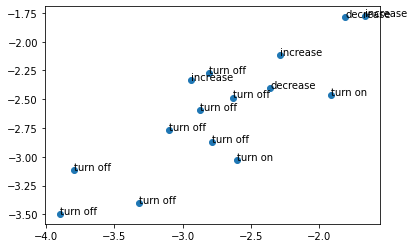

In [3]:
# Visualization of word 3 vector embedding
vector_size = 4
model = Word2Vec(sentences = X,vector_size=vector_size,window=1, min_count=10)
testNR = 15
wordVecs = np.empty((testNR,vector_size))
X_vec  = []

for i in range(testNR):
    value = np.zeros((vector_size,))
    for word in X[i]:
        value += np.array(model.wv[word])
    wordVecs[i,:] = value


plt.scatter(wordVecs[:,0],wordVecs[:,1])

for i in range(testNR):
    plt.text(wordVecs[i,0],wordVecs[i,1],y[i][0])

In [4]:
# Attempt at making some actuall practical stuff
vector_size = 50
model = Word2Vec(sentences = X,vector_size=vector_size,window=1, min_count=1)
model.train(y[:][0],total_examples=N,epochs = 100)
X_vec = np.empty((N,vector_size))
y_vec = np.empty((N,vector_size))
for i in range(N):
    # Constructing sentence feature
    value_iter = np.zeros((vector_size,))
    for word in X[i]:
        try:
            value_iter += np.array(model.wv[word])  # / len(X[i]) Seems resonable to do but gives terrible performance
        except:
            print('Issue for: X=',i,'with word "', word,'".')
            print('Word ignored in feature construction.')
    X_vec[i,:] = value_iter

    # Constructing keywords output
    value_iter = np.zeros((vector_size,))
    for key in y[i]:
        words = key.split(' ')
        for word in words:
            value_iter += np.array(model.wv[word])  # / len(y[i]) Seems resonable to do but gives terrible performance
    y_vec[i,:] = value_iter

print(X_vec.shape)
print(y_vec.shape)

(564, 50)
(564, 50)


In [5]:
# Attempt at making proper prediction
def least_squares(y,tx):
    w = np.linalg.inv(tx.T @ tx) @ tx.T @ y
    return w

def makePrediction(X,w):
    return X @ w

# Split data
splitC = 0.5
splitIDX = int(N*splitC)
y_train = y_vec[0:splitIDX,:]
X_train = X_vec[0:splitIDX,:]
y_test = y_vec[splitIDX+1:,:]
X_test = X_vec[splitIDX+1:,:]

W = least_squares(y_train,X_train)
y_pred = makePrediction(X_train,W)

In [6]:
# Make prediction based on smallest distance to vector
def minDist2Set(y,Y):
    n = Y.shape[0]
    dY = np.zeros(n)
    for i in range(n):
        dY[i] = np.linalg.norm(y-Y[i,:])
    return np.argmin(dY)

accuracy = 0
for i in range(splitIDX-1):
    i_pred = minDist2Set(y_pred[i,:],y_test)
    if y[i_pred][0] == y[i][0]:
        accuracy +=1
accuracy = accuracy / N
print(accuracy)

0.11347517730496454


# Using Pandas data frames

In [3]:
# Preprocessing testing
data = pd.read_json('metadata.json',orient = 'index')
# Select data that is needed
data_sentences = data[['transcript','keywords']]
# Print data info
pd.Series(data_sentences['keywords'].sum()).value_counts()

kitchen        193
brightness     192
bedroom        187
living room    184
increase       144
decrease       143
turn on        139
turn off       139
dtype: int64

In [6]:
#keywords to user action
data_sentences['user_actions'] = 0

for index, rows in data_sentences.iterrows():
    if('turn off' in  rows.keywords):
        data_sentences.loc[index,'user_actions'] = 'SwitchLightOff'
    elif('turn on' in  rows.keywords):
        data_sentences.loc[index,'user_actions'] = 'SwitchLightOn'
    elif('increase' in rows.keywords):
        is_num_in_actions = [element.isdigit()  for element in rows.keywords]
        if(True in is_num_in_actions):
            data_sentences.loc[index,'user_actions'] = 'SetLightBrightness'
        else:
            data_sentences.loc[index,'user_actions'] = 'IncreaseBrightness'
    elif('decrease' in rows.keywords):
        is_num_in_actions = [element.isdigit()  for element in rows.keywords]
        if(True in is_num_in_actions):
            data_sentences.loc[index,'user_actions'] = 'SetLightBrightness'
        else:
            data_sentences.loc[index,'user_actions'] = 'DecreaseBrightness'
    else:
        is_color_in_actions = [is_color_like(element)  for element in rows.keywords]
        if(True in is_color_in_actions):
            data_sentences.loc[index,'user_actions'] = 'SetLightColor'
        else:
            data_sentences.loc[index,'user_actions'] = 'Nullaction'

<ipython-input-6-1a63e9aa8683>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sentences['user_actions'] = 0


In [7]:
print(data_sentences.loc[:,'keywords'])

record_b527de37-35e3-48d9-8c8e-3f9672ccdd79_16k_c1    [turn off, living room]
record_58ea6b9c-f9f4-43d2-bc6d-503a43f8da9d_16k_c1        [decrease, bedroom]
record_6224b626-12f4-48ff-ac9a-d28ee57ed70b_16k_c1    [increase, living room]
record_fa3339c0-22b3-4650-8c48-111411eebfeb_16k_c1        [increase, bedroom]
record_5a2c371e-43f8-4be9-9ec5-7b542b075b3a_16k_c1        [turn off, bedroom]
                                                               ...           
record_f02159ce-cae6-4e03-9c1a-9c17ddcf70bf_16k_c1        [increase, kitchen]
record_1c94b803-396f-4ec5-8dd6-7c2ccc0eea38_16k_c1         [turn on, bedroom]
record_9bcdf971-c5b2-4898-b511-58ecfed6826e_16k_c1    [turn off, living room]
record_0ca383f2-9aaf-43df-bbcc-b40920072b63_16k_c1        [turn off, kitchen]
record_557a5b9c-a18b-4fca-88de-3ce3cbeb014d_16k_c1        [turn off, kitchen]
Name: keywords, Length: 564, dtype: object
